# Building the ego network

The goal of this ego network analysis would be to compare the film industry network of different countries/industries. To do so, we will have the following plan :

- Build ego networks for the most "important" actors in different industries/countries. We will chose 4 or 5 countries and 4 or 5 actors. 
- Then on these country groups perform an analysis of the ego networks.
- Finally compare the values for each country and draw conclusions.

For countries, we choose : the United States of America, France, India, United Kingdom, based on availabity of our dataset and the movie box office revenue, took from : https://en.wikipedia.org/wiki/Film_industry

### Libs

In [3]:
# import required libraries
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import ast

# sentiment analysis
# import vaderSentiment

# graphs handling
#from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

# set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Loading the data

In [4]:
# set data paths
DATA_FOLDER = 'Data/'

CHARACTER_META = DATA_FOLDER+'character.metadata.tsv'
MOVIE_META = DATA_FOLDER+'movie.metadata.tsv'
NAME_CLUSTERS = DATA_FOLDER+'name.clusters.txt'
PLOT_SUMM = DATA_FOLDER+'plot_summaries.txt'
TV_TROPES = DATA_FOLDER+'tvtropes.clusters.txt'

In [5]:
# load movies metadata
movie_meta = pd.read_csv(MOVIE_META, sep='\t', header=None)

movie_meta.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue',
                     'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

# load characters metadata
character_meta = pd.read_csv(CHARACTER_META, sep='\t', header=None)
character_meta.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date' ,'character_name', 'actor_date_of_birth', 'actor_gender',
                    'actor_height_m', 'actor_ethnicity_id', 'actor_name', 'actor_age_at_movie_release', 'freebase_character/actor_map_id',
                    'freebase_character_id', 'freebase_actor_id']

# load charcter name clusters
name_clusters = pd.read_csv(NAME_CLUSTERS, sep='\t', header=None)
name_clusters.columns = ['character_name', 'freebase_character/actor_map_id']

# load plot summaries
plot_summ = pd.read_csv(PLOT_SUMM, sep='\t', header=None)
plot_summ.columns = ['wikipedia_movie_id', 'summary']

# load tv tropes
tv_tropes = pd.read_csv(TV_TROPES, sep='\t', header=None)
tv_tropes.columns = ['character_type', 'freebase_character/actor_map_id']

### Actor to actor graph per country

In [6]:
## Finding movie's country code names

In [124]:
countries= ['{"/m/09c7w0": "United States of America"}', '{"/m/07ssc": "United Kingdom"}',
          '"/m/0f8l9c": "France"', '{"/m/03rk0": "India"}']


In [149]:
def contains_country(x):
    if (len(x.split(':'))>1) :
        if ('France' in x.split(':')[1]) :
            return 1
        else : return 0
    else : return 0

In [151]:
movie_meta['ctry'] = movie_meta['movie_countries'].apply(contains_country)
movie_meta[movie_meta['ctry']==1].head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,ctry
26,22087420,/m/05pckh0,"Ferdinando I, re di Napoli",1959-12-22,NaN,105.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/01z4y"": ""Comedy"", ""/m/01g6gs"": ""Black-and-white""}",1
81,27374355,/m/0by1_ff,Les Indiens sont encore loin,NaN,NaN,95.0,{},"{""/m/0f8l9c"": ""France"", ""/m/06mzp"": ""Switzerland""}","{""/m/07s9rl0"": ""Drama""}",1
120,28415406,/m/0crj1f3,The Last Trackers of the Outback,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/0chghy"": ""Australia""}","{""/m/0jtdp"": ""Documentary""}",1
138,22066590,/m/05p3428,The Bigamist,1956-09-20,NaN,110.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/05p553"": ""Comedy film"", ""/m/01g6gs"": ""Black-and-white""}",1
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,135.0,"{""/m/012psb"": ""Romani language"", ""/m/02bjrlw"": ""Italian Language"", ""/m/06x8y"": ""Serbo-Croatian"", ""/m/01bkv"": ""Bulgarian Language"", ""/m/0k0sb"": ""Serbian language"", ""/m/04306rv"": ""German Language""}","{""/m/0f8l9c"": ""France"", ""/m/087vz"": ""Yugoslavia"", ""/m/0345h"": ""Germany""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""Comedy"", ""/m/04rlf"": ""Music"", ""/m/0hj3mz5"": ""Comedy of Errors"", ""/m/02l7c8"": ""Romance Film"", ""/m/09q17"": ""Slapstick""}",1


In [7]:
# Dataframes for movies produced in each of the wanted countries

df_usa = movie_meta.apply(lambda x : '"/m/09c7w0": "United States of America"' in x['movie_countries'], axis=1)
df_usa = movie_meta[df_usa]

df_india = movie_meta.apply(lambda x : '"/m/03rk0": "India"' in x['movie_countries'], axis=1)
df_india = movie_meta[df_india]

df_uk = movie_meta.apply(lambda x : '"/m/07ssc": "United Kingdom"' in x['movie_countries'], axis=1)
df_uk = movie_meta[df_uk]

df_fr = movie_meta.apply(lambda x : '"/m/0f8l9c": "France"' in x['movie_countries'], axis=1)
df_fr = movie_meta[df_fr]

In [8]:
print("The number of american films is : {usa}".format(usa=len(df_usa)))
print("The number of indian films is : {india}".format(india=len(df_india)))
print("The number of uk films is : {uk}".format(uk=len(df_uk)))
print("The number of french films is : {fr}".format(fr=len(df_fr)))

The number of american films is : 34408
The number of indian films is : 8411
The number of uk films is : 7868
The number of french films is : 4395


In [9]:
# We keep only the informations that we care about
actor_to_movies = character_meta[['freebase_actor_id','freebase_movie_id']]

In [10]:
## Creating dataframes of actors for each country

usa_char = actor_to_movies[actor_to_movies['freebase_movie_id'].isin(list(df_usa['freebase_movie_id']))]
uk_char = actor_to_movies[actor_to_movies['freebase_movie_id'].isin(list(df_uk['freebase_movie_id']))]
fr_char = actor_to_movies[actor_to_movies['freebase_movie_id'].isin(list(df_fr['freebase_movie_id']))]
india_char = actor_to_movies[actor_to_movies['freebase_movie_id'].isin(list(df_india['freebase_movie_id']))]

In [11]:
# We construct per country actor to movies dicts

usa_actors_movies = dict(usa_char.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id'])))
uk_actors_movies = dict(uk_char.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id'])))
fr_actors_movies = dict(fr_char.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id'])))
india_actors_movies = dict(india_char.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id'])))

In [12]:
# We construct per country movie to actors dicts

usa_movies_actors = dict(usa_char.groupby('freebase_movie_id').apply(
    lambda x: list(x['freebase_actor_id'])))
uk_movies_actors = dict(uk_char.groupby('freebase_movie_id').apply(
    lambda x: list(x['freebase_actor_id'])))
fr_movies_actors = dict(fr_char.groupby('freebase_movie_id').apply(
    lambda x: list(x['freebase_actor_id'])))
india_movies_actors = dict(india_char.groupby('freebase_movie_id').apply(
    lambda x: list(x['freebase_actor_id'])))

### Creating per country of movie production graphs

In [383]:
G_usa = nx.graph.Graph()
G_uk = nx.graph.Graph()
G_fr = nx.graph.Graph()
G_india = nx.graph.Graph()

In [384]:
def add_nodes(Graph, actor_movie_map):
    for key in actor_movie_map.keys():
        Graph.add_node(key)

In [385]:
# We make the first actor-to-actor graphs.
# We construct the graphs with actor nodes, for each country.

add_nodes(G_usa, usa_actors_movies)
add_nodes(G_uk, uk_actors_movies)
add_nodes(G_fr, fr_actors_movies)
add_nodes(G_india, india_actors_movies)

In [386]:
def add_edges(Graph, actor_movie_map, movie_actors_map):
    # For each actor, we get the movies he played in
    for key in actor_movie_map.keys():
        set_of_movies = set(actor_movie_map[key])
        list_of_actors = []
        # For each movies, we get the list of actors that played in them
        for movie in set_of_movies:
            actors_for_one_movie = set(movie_actors_map[movie]) 
            list_of_actors += list(actors_for_one_movie)
        # We get a final list of all the actors an actor has co-starred with 
        # and remove the original actor so that we have no self-edge
        final_list_of_actors = set(list_of_actors) - set(key)
        # We transform the list of actors into a list of tuples of the shape (actor, actor) ( which will be the edges the networkx graph will add )
        final_list_of_actors = map(lambda x: (key, x), final_list_of_actors)
        # We add thes edges ( connections ) to the graph
        Graph.add_edges_from(final_list_of_actors)
        

def add_edges_weighted(Graph, movie_actors_map):
    # iterate through the movies
    for movie in movie_actors_map:
        # get the list of actors in the movie
        movie_actors = movie_actors_map[movie]
        # iterate through the pairs of actors in the movie
        for i, actor1 in enumerate(movie_actors):
            for actor2 in movie_actors[i+1:]:
                # add an edge between the actors if it doesn't exist
                if not Graph.has_edge(actor1, actor2):
                    Graph.add_edge(actor1, actor2, weight=0)
                # increase the weight of the edge by 1
                Graph[actor1][actor2]['weight'] += 1
                

In [387]:
%%time
# We add weighted edges for each graph
add_edges_weighted(G_usa, usa_movies_actors)
add_edges_weighted(G_uk, uk_movies_actors)
add_edges_weighted(G_fr, fr_movies_actors)
add_edges_weighted(G_india, india_movies_actors)

CPU times: user 5.04 s, sys: 58.6 ms, total: 5.1 s
Wall time: 5.1 s


In [393]:
# We remove self-loop edges
G_usa.remove_edges_from(nx.selfloop_edges(G_usa))
G_uk.remove_edges_from(nx.selfloop_edges(G_uk))
G_fr.remove_edges_from(nx.selfloop_edges(G_fr))
G_india.remove_edges_from(nx.selfloop_edges(G_india))

We select the ego nodes for each country based on the degree centrality, we sample the ten most "important" nodes, and create ego networks for them, per country

In [394]:
%%time
# Compute and select the top 10 most important nodes per country, based on degree centrality

usa_egos = sorted(nx.degree_centrality(G_usa).items(), key=lambda x: x[1], reverse=True)[1:11]
uk_egos = sorted(nx.degree_centrality(G_uk).items(), key=lambda x: x[1], reverse=True)[:10]
fr_egos = sorted(nx.degree_centrality(G_fr).items(), key=lambda x: x[1], reverse=True)[:10]
india_egos = sorted(nx.degree_centrality(G_india).items(), key=lambda x: x[1], reverse=True)[:10]

CPU times: user 143 ms, sys: 3.78 ms, total: 147 ms
Wall time: 175 ms


In [395]:
%%time
fr_ego_names = [x[0] for x in fr_egos]
fr_ego_names = [(ego, character_meta[character_meta['freebase_actor_id']==ego]['actor_name'].values[0]) for ego in fr_ego_names]

usa_ego_names = [x[0] for x in usa_egos]
usa_ego_names = [(ego, character_meta[character_meta['freebase_actor_id']==ego]['actor_name'].values[0]) for ego in usa_ego_names]

uk_ego_names = [x[0] for x in uk_egos]
uk_ego_names = [(ego, character_meta[character_meta['freebase_actor_id']==ego]['actor_name'].values[0]) for ego in uk_ego_names]

india_ego_names = [x[0] for x in india_egos]
india_ego_names = [(ego, character_meta[character_meta['freebase_actor_id']==ego]['actor_name'].values[0]) for ego in india_ego_names]

CPU times: user 821 ms, sys: 3.67 ms, total: 825 ms
Wall time: 824 ms


### We create the ego networks for each country separately as each country needs its own preprocessing of nodes and edges

In [506]:
def filter_edges(Graph, treshold):
    ### Removing edges bellow number of movies in common between actors

    # create a list of edges to be removed
    edges_to_remove = [(u, v) for u, v, data in Graph.edges(data=True) if data['weight'] < treshold]

    # remove the edges from the graph
    Graph.remove_edges_from(edges_to_remove)

In [547]:
#filtering the nodes bellow a given nomber of connections
def filter_k_core(Graph, k, ego_names, ego_network):

    # compute the k-core of the ego network
    k_core = [nx.k_core(ego_network[i], k) for i in range(len(ego_names))]

    # extract the k-core subgraph of the ego network
    k_core_subgraph = [nx.subgraph(ego_network[i], k_core[i]) for i in range(len(ego_names))]
    
    return k_core_subgraph

In [399]:
def plot_ego_nets(Graph, ctry_name, actor_names, color):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    for i, subplot in enumerate(ax.flat):
        # draw the graph in the current subplot
        nx.draw(Graph[i], node_size=15, node_color=color, ax=subplot)
        
        # add a label to the subplot
        subplot.set_title("{name}".format(name=actor_names[i][1]))
        
    plt.suptitle("Ego networks of the top10 most important actors, based on degree centrality, in {ctry_n} movies".format(ctry_n=ctry_name))
    # show the plot
    plt.show()

### USA 

The processing of the graph for the USA was done in the following way :

- We first created the graph normally and removed edges between actors that have less that 2 films in common
- We then used k_core to removed nodes that have less than 3 relations with other actors

In [548]:
usa_ego_network = [nx.ego_graph(G_usa, ego[0]) for ego in usa_ego_names]

In [549]:
%%time
### Removing edges bellow number of movies in common between actors
usa_edge_tresh = 2
filter_edges(G_usa, usa_edge_tresh)

CPU times: user 108 ms, sys: 3.42 ms, total: 111 ms
Wall time: 110 ms


In [550]:
%%time
# extract the k-core subgraph of the ego network
k_usa = 3
k_core_subgraph_usa = filter_k_core(G_usa, k_usa, usa_ego_names, usa_ego_network)

CPU times: user 51.1 ms, sys: 1.91 ms, total: 53 ms
Wall time: 51.8 ms


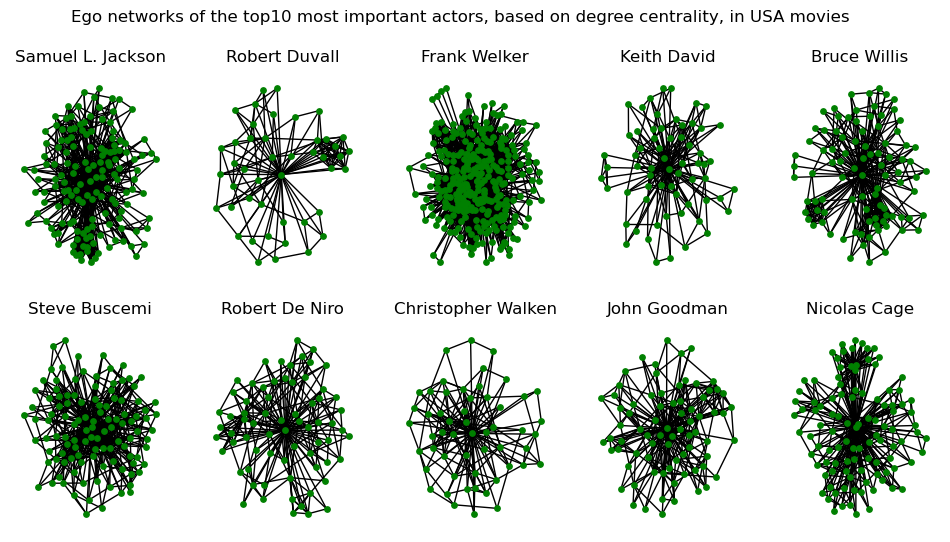

In [553]:
plot_ego_nets(k_core_subgraph_usa, 'USA', usa_ego_names, 'green')

### France

In [554]:
fr_ego_network = [nx.ego_graph(G_fr, ego[0]) for ego in fr_ego_names]

In [555]:
%%time
# extract the k-core subgraph of the ego network
k_fr = 15
k_core_subgraph_fr = filter_k_core(G_fr, k_fr, fr_ego_names, fr_ego_network)

CPU times: user 111 ms, sys: 2.37 ms, total: 114 ms
Wall time: 113 ms


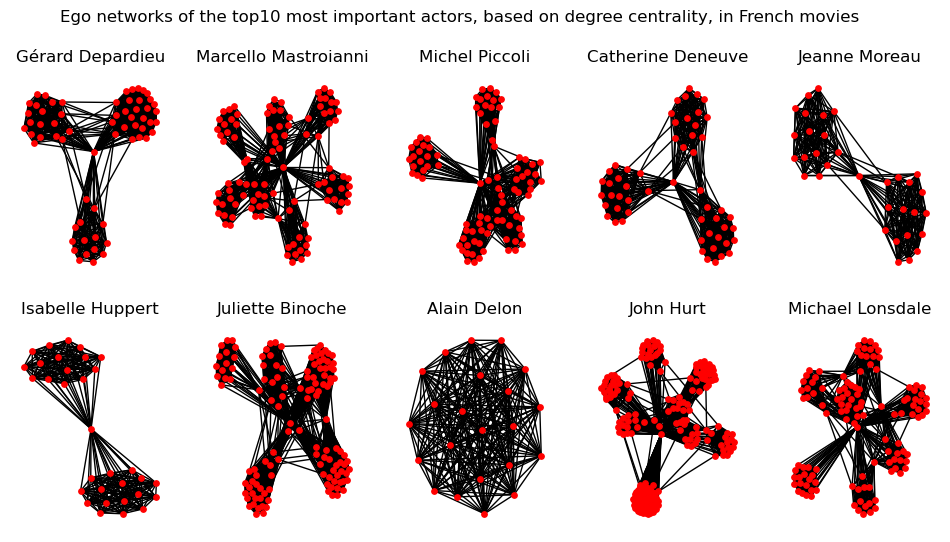

In [556]:
plot_ego_nets(k_core_subgraph_fr, 'French', fr_ego_names, 'red')

### UK

In [557]:
G_uk = nx.graph.Graph()
add_nodes(G_uk, uk_actors_movies)
add_edges_weighted(G_uk, uk_movies_actors)

In [559]:
G_uk.remove_edges_from(nx.selfloop_edges(G_uk))

In [561]:
uk_ego_network = [nx.ego_graph(G_uk, ego[0]) for ego in uk_ego_names]

In [562]:
G_uk.size()

280746

In [ ]:
%%time
### Removing edges bellow number of movies in common between actors
uk_edge_tresh = 5
filter_edges(G_uk, usa_edge_tresh)

In [541]:
%%time
# extract the k-core subgraph of the ego network
k_uk = 15
k_core_subgraph_uk = filter_k_core(G_uk, k_uk, uk_ego_names, uk_ego_network)

CPU times: user 1.3 s, sys: 11.5 ms, total: 1.31 s
Wall time: 1.32 s


In [534]:
G_uk.size()

146

In [535]:
len(k_core_subgraph_uk[2].nodes())

490

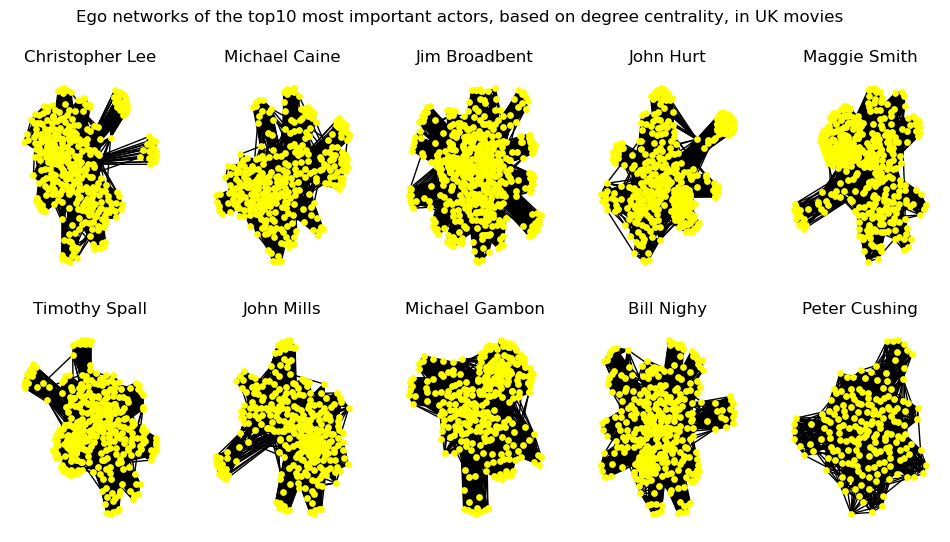

CPU times: user 4.46 s, sys: 47 ms, total: 4.51 s
Wall time: 4.53 s


In [536]:
%%time
plot_ego_nets(k_core_subgraph_uk, 'UK', uk_ego_names, 'yellow')

In [492]:
k_core_subgraph_uk[0].size()

695

#### India

### Continuity with no weighted edges in country ego networks

In [18]:
print("USA graph size {us_len}".format(us_len=G_usa.size()))
print("UK graph size {uk_len}".format(uk_len=G_uk.size()))
print("FR graph size {fr_len}".format(fr_len=G_fr.size()))
print("India graph size {india_len}".format(india_len=G_india.size()))

USA graph size 1368740
UK graph size 302342
FR graph size 171901
India graph size 137025


In [19]:
# We remove self-loop edges
G_usa.remove_edges_from(nx.selfloop_edges(G_usa))
G_uk.remove_edges_from(nx.selfloop_edges(G_uk))
G_fr.remove_edges_from(nx.selfloop_edges(G_fr))
G_india.remove_edges_from(nx.selfloop_edges(G_india))

In [20]:
print("USA graph size {us_len}".format(us_len=G_usa.size()))
print("UK graph size {uk_len}".format(uk_len=G_uk.size()))
print("FR graph size {fr_len}".format(fr_len=G_fr.size()))
print("India graph size {india_len}".format(india_len=G_india.size()))

USA graph size 1297677
UK graph size 280746
FR graph size 154786
India graph size 130422


In [21]:
print("USA node nb {us_nodes}".format(us_nodes=len(G_usa.nodes)))
print("UK node nb {uk_nodes}".format(uk_nodes=len(G_uk.nodes)))
print("FR node nb {fr_nodes}".format(fr_nodes=len(G_fr.nodes)))
print("India node nb {india_nodes}".format(india_nodes=len(G_india.nodes)))

USA node nb 71064
UK node nb 21597
FR node nb 17116
India node nb 6604


#### Compute degree centrality on the graphs, to reduce the size

After having built the graph between actors, we have to carefully select "important" nodes to build ego networks around them.

In [408]:
## Building the french ego networks

fr_ego_network = [nx.ego_graph(G_fr, ego[0]) for ego in fr_egos]

# compute the k-core of the ego network
k = 15
k_core_fr = [nx.k_core(fr_ego_network[i], k) for i in range(len(fr_egos))]

# extract the k-core subgraph of the ego network
k_core_subgraph_fr = [nx.subgraph(fr_ego_network[i], k_core_fr[i]) for i in range(len(fr_egos))]

In [134]:
# We build and display ego networks for the countries

# compute the k-core of the ego network
fr_ego_network = [nx.ego_graph(G_fr, ego[0]) for ego in fr_egos]
usa_ego_network = [nx.ego_graph(G_usa, ego[0]) for ego in usa_egos]
uk_ego_network = [nx.ego_graph(G_uk, ego[0]) for ego in uk_egos]
india_ego_network = [nx.ego_graph(G_india, ego[0]) for ego in india_egos]

# compute the k-core of the ego network
k = 15 
k_core_fr = [nx.k_core(fr_ego_network[i], k) for i in range(len(fr_egos))]
k_core_usa = [nx.k_core(usa_ego_network[i], 60) for i in range(len(usa_egos))]
k_core_uk = [nx.k_core(uk_ego_network[i], 30) for i in range(len(uk_egos))]
k_core_india = [nx.k_core(india_ego_network[i], 30) for i in range(len(india_egos))]

# extract the k-core subgraph of the ego network
k_core_subgraph_fr = [nx.subgraph(fr_ego_network[i], k_core_fr[i]) for i in range(len(fr_egos))]
k_core_subgraph_usa = [nx.subgraph(usa_ego_network[i], k_core_usa[i]) for i in range(len(usa_egos))]
k_core_subgraph_uk = [nx.subgraph(uk_ego_network[i], k_core_uk[i]) for i in range(len(uk_egos))]
k_core_subgraph_india = [nx.subgraph(india_ego_network[i], k_core_india[i]) for i in range(len(india_egos))]

In [155]:
k_core_usa = [nx.k_core(usa_ego_network[i], 50) for i in range(len(usa_egos))]
k_core_subgraph_usa = [nx.subgraph(usa_ego_network[i], k_core_usa[i]) for i in range(len(usa_egos))]

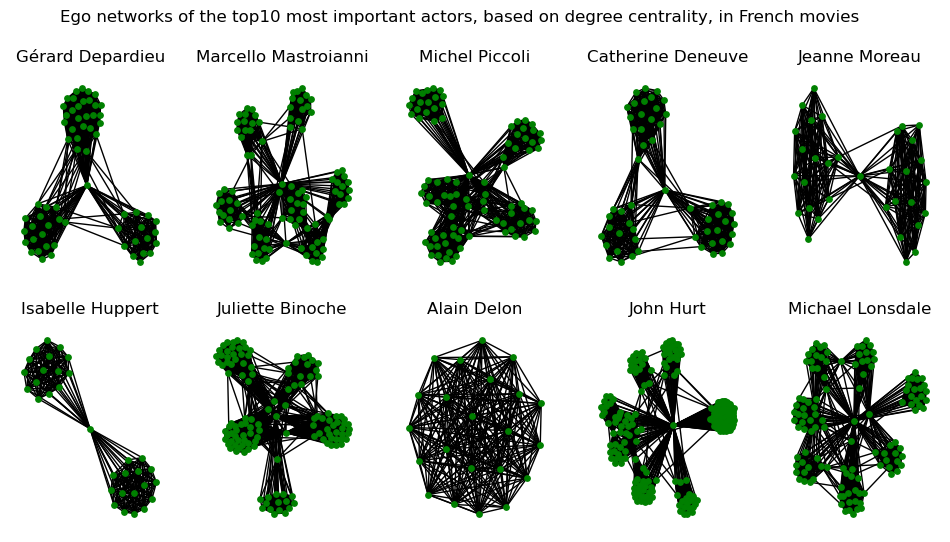

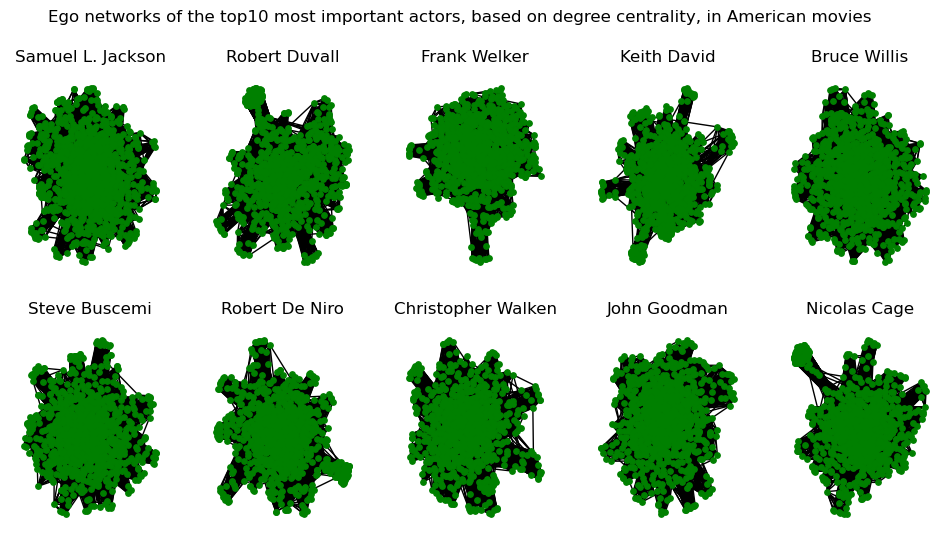

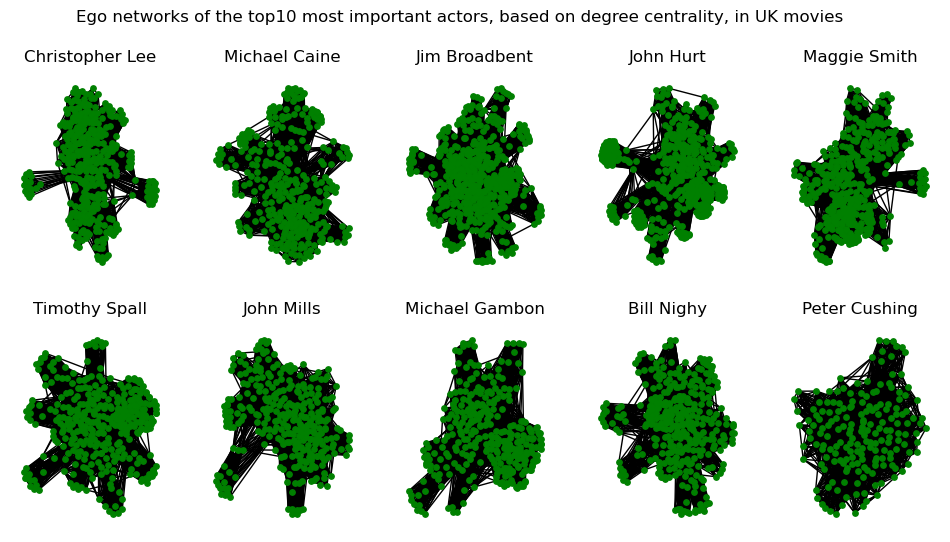

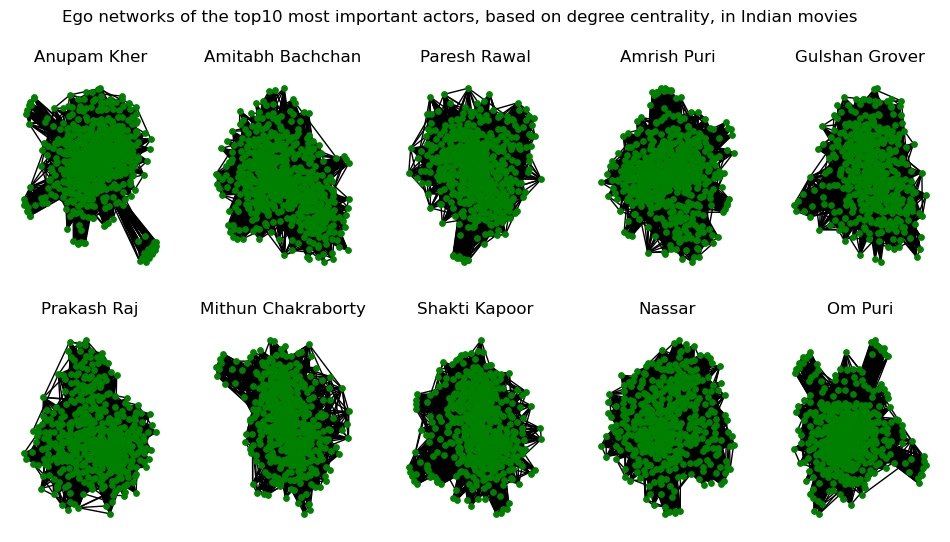

In [125]:
k_core_subgraphs = [k_core_subgraph_fr, k_core_subgraph_usa, k_core_subgraph_uk, k_core_subgraph_india]
ego_names_ctry = [fr_ego_names, usa_ego_names, uk_ego_names, india_ego_names]
colors = ['green', 'blue', 'red', 'yellow']
countries = ['French', 'American', 'UK', 'Indian']

for ctries in range(len(ego_names_ctry)):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    for i, subplot in enumerate(ax.flat):
        # draw the graph in the current subplot
        nx.draw(k_core_subgraphs[ctries][i], node_size=15, node_color='green', ax=subplot)
        
        # add a label to the subplot
        subplot.set_title("{name}".format(name=ego_names_ctry[ctries][i][1]))
        
    plt.suptitle("Ego networks of the top10 most important actors, based on degree centrality, in {ctry_name} movies".format(ctry_name=countries[ctries]))
    # show the plot
    plt.show()
        


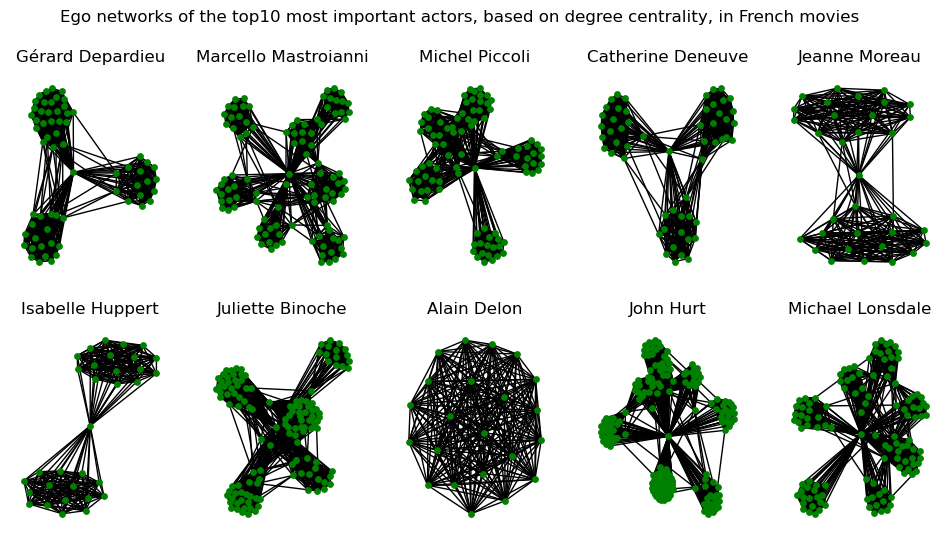

In [123]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i, subplot in enumerate(ax.flat):
    
    # draw the graph in the current subplot
    nx.draw(k_core_subgraph_fr[i], node_size=15, node_color='green', ax=subplot)
    
    # add a label to the subplot
    subplot.set_title("{name}".format(name=fr_ego_names[i][1]))
    
plt.suptitle("Ego networks of the top10 most important actors, based on degree centrality, in French movies")
# show the plot
plt.show()